In [1]:
import scanpy as sc
import os
import anndata as ad
# Python packages
import scvi
import bbknn
import scib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
from scipy.stats import median_abs_deviation
from statsmodels import robust
import warnings
warnings.filterwarnings("ignore")

pd.set_option('display.max_columns', None)
import scanpy.external as sce

/home/icb/yuting.wang/tools/miniconda3/envs/interoperability/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.7.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


In [2]:
#check if GPU is available
import torch
if torch.cuda.is_available():
    print("GPU is available")
    print(f"Device count: {torch.cuda.device_count()}")
    print(f"Device name: {torch.cuda.get_device_name(0)}")
else:
    print("GPU is not available")

GPU is available
Device count: 1
Device name: Tesla V100-SXM3-32GB


# 1. Filter low quality cells

In [3]:
def add_qc_metrics(adata):
    # Add QC metrics
    adata.var["mt"] = adata.var['gene_symbol'].str.startswith("MT-")  # mitochondrial genes
    adata.var["ribo"] = adata.var['gene_symbol'].str.startswith(("RPS", "RPL"))  # ribosomal genes
    adata.var["hb"] = adata.var['gene_symbol'].str.contains(("^HB[^(P)]"))  # hemoglobin genes

    # Print the number of QC genes
    print("The number of mitochondrial genes is " + str(adata.var["mt"].sum()))
    print("The number of ribosomal genes is " + str(adata.var["ribo"].sum()))
    print("The number of hemoglobin genes is " + str(adata.var["hb"].sum()))

    # Check for NaN values in adata.var
    print(f"The number of NaN values: {adata.var[['mt', 'ribo', 'hb']].isnull().sum()}")

    # Calculate QC metrics
    sc.pp.calculate_qc_metrics(adata, qc_vars=["mt", "ribo", "hb"], inplace=True, percent_top=[20], log1p=True)

    # Visualize
    sns.displot(adata.obs["total_counts"], bins=100, kde=False)
    sc.pl.violin(adata, "pct_counts_mt")
    sc.pl.scatter(adata, "total_counts", "n_genes_by_counts", color="pct_counts_mt")

    return adata


# Second function to filter based on automatic thresholding
def automatic_filtering(adata, study):
    def is_outlier(adata, metric: str, nmads: int):
        M = adata.obs[metric]
        outlier = (M < np.median(M) - nmads * robust.mad(M)) | (
            np.median(M) + nmads * robust.mad(M) < M
            )
        return outlier

    # Detect outliers based on total counts, genes, etc.
    adata.obs["outlier"] = (
        is_outlier(adata, "log1p_total_counts", 5)
        | is_outlier(adata, "log1p_n_genes_by_counts", 5)
        | is_outlier(adata, "pct_counts_in_top_20_genes", 5)
    )
    outlier_count = adata.obs.outlier.value_counts().get(True, 0)

    # Detect mitochondrial outliers
    adata.obs["mt_outlier"] = is_outlier(adata, "pct_counts_mt", 3) | (adata.obs["pct_counts_mt"] > 8)
    mt_outlier_count = adata.obs.mt_outlier.value_counts().get(True, 0)

    # Before and after filtering
    print(f"Total number of cells before filtering: {adata.n_obs}")
    n_cells_pre = adata.n_obs
    adata = adata[(~adata.obs.outlier) & (~adata.obs.mt_outlier)].copy()
    n_cells_post = adata.n_obs
    print(f"Total number of cells after filtering: {adata.n_obs}")
    print(f"Number of cells removed: {n_cells_pre - n_cells_post}")

    # Visualization after filtering
    sc.pl.scatter(adata, "total_counts", "n_genes_by_counts", color="pct_counts_mt", title=f"Filtered Total Counts vs. Number of Genes - {study}")
    plt.savefig(os.path.join(plot_dir, f"filtered_total_counts_vs_n_genes_{study}.png"))
    plt.close()

    return adata, n_cells_pre, n_cells_post, outlier_count, mt_outlier_count



In [5]:
# List of datasets and the directory path
studies = [
    'Kropski_Banovich_unpubl.h5ad', 
    'Yildirim_unpubl.h5ad',
    'Shaykhiev_publ.h5ad',
    'Schiller_unpubl.h5ad',
    'Nawijn_unpubl.h5ad', 
    'lungMAP.h5ad', 
    'Jones_Yosef_Teichmann_Farber_Sims_unpubl.h5ad',
    'Niklason_Kaminski_publ.h5ad'
]

all_path = '/ictstr01/groups/ml01/projects/2024_hlca_v2_raphael.kfurirubens/core_all_datasets/adata_postrevision_reduced_w_labels'
write_path = './data/filtered_data'
plot_dir = './plots'
summary_table = []

# Loop over datasets, process each, and save the results
for study in studies:
    dataset_path = os.path.join(all_path, study)  # Construct the full path
    print(f"Processing dataset: {dataset_path}")
    
    # Load dataset
    adata = sc.read_h5ad(dataset_path)
    
    # Apply QC metrics and visualize before filtering
    adata = add_qc_metrics(adata)
    
    # Apply automatic filtering and get metrics
    adata, n_cells_pre, n_cells_post, outlier_count, mt_outlier_count = automatic_filtering(adata, study)
    
    # Save the filtered dataset with a new name
    filtered_path = os.path.join(write_path, f"filtered_{study}")
    adata.write(filtered_path)
    print(f"Filtered dataset saved as: {filtered_path}")

    # Collect metrics for summary table
    summary_table.append({
        "Study": study,
        "Total Cells (Before)": n_cells_pre,
        "Total Cells (After)": n_cells_post,
        "Outliers": outlier_count,
        "Mitochondrial Outliers": mt_outlier_count,
        "Outlier Ratio": outlier_count / n_cells_pre if n_cells_pre > 0 else 0,
        "Mitochondrial Outlier Ratio": mt_outlier_count / n_cells_pre if n_cells_pre > 0 else 0,
    })

# Create a DataFrame for the summary table
summary_df = pd.DataFrame(summary_table)

# Save the summary table to a CSV file
summary_df.to_csv('./data/summary_table.csv', index=False)
print("Summary table saved as: ./data/summary_table.csv")


### Concatenate filtered_data

- drop var columns
- save to './data/241001_raw_data.h5ad'
- add adata.obs['file_name']
- add condition (normal/copd)

In [ ]:
# List of file names
all_files = [
    'Kropski_Banovich_unpubl.h5ad', 
    'Shaykhiev_publ.h5ad', 
    'Schiller_unpubl.h5ad', 
    'Yildirim_unpubl.h5ad', 
    'lungMAP.h5ad', 
    'Nawijn_unpubl.h5ad', 
    'Jones_Yosef_Teichmann_Farber_Sims_unpubl.h5ad',
    'Niklason_Kaminski_publ.h5ad'
]

# Mapping between 'PATO:0000461' or 'MONDO:0005002' and condition
condition_mapping = {
    'PATO:0000461': 'normal',
    'PATO:0000461 ': 'normal',  # Handle extra space in key
    'MONDO:0005002': 'copd'
}

# Initialize an empty list to hold the AnnData objects
adata_list = []

# Directory path where files are stored
data_dir = './data/filtered_data'
# Loop over each file, read it, and append it to the list
for file in all_files:
    file_path = os.path.join(data_dir, 'filtered_'+file)
    
    if os.path.exists(file_path):
        adata = sc.read(file_path)
        #different datasets have different var, lets drop
        adata.var.drop(columns=adata.var.columns, inplace=True)
        # Check the 'disease_ontology_term_id' column for values indicating 'PATO:0000461' or 'MONDO:0005002'
        if 'disease_ontology_term_id' in adata.obs.columns:
            # Convert 'disease_ontology_term_id' to string to avoid mapping errors
            adata.obs['disease_ontology_term_id'] = adata.obs['disease_ontology_term_id'].astype(str)
            
            # Apply the condition mapping to the 'disease_ontology_term_id' column
            adata.obs['condition'] = adata.obs['disease_ontology_term_id'].map(condition_mapping)
            
            # Handle missing categories by adding 'Unknown' as a new category
            adata.obs['condition'] = adata.obs['condition'].astype('category')
            adata.obs['condition'] = adata.obs['condition'].cat.add_categories('Unknown').fillna('Unknown')
        else:
            adata.obs['condition'] = 'Unknown'
        
        # Add 'file_name' column in the obs attribute
        adata.obs['file_name'] = os.path.basename(file)
        
        # Append the annotated AnnData object to the list
        adata_list.append(adata)
    else:
        print(f"File {file} not found in directory")

# Concatenate all AnnData objects, using only common genes across datasets
# Unpack the list of AnnData objects using the * operator
adata = sc.AnnData.concatenate(
    *adata_list,  # Unpack the list here
    join="outer",  # Use 'outer' to include all genes across datasets
    batch_key=None,  # Optionally add a key to track batches
    batch_categories=None,  # Use study names as batch categories
    index_unique=None  # Avoid adding any suffix to indices
)

# Print the shape of the concatenated AnnData object
print(adata.shape)

# Optionally, you can save the concatenated dataset to a file
output_path = './data/241001_afterQC_data.h5ad'
os.makedirs(os.path.dirname(output_path), exist_ok=True)  # Create output folder if it doesn't exist
adata.write(output_path)
print(f"Concatenation complete and saved to '{output_path}'")


# Load QC_filtered data, apply other basic filters (cell, gene numbers)

In [6]:
output_path = './data/241001_afterQC_data.h5ad'
adata = sc.read(output_path)

### Subset dataset to only normal for data integration first

In [7]:
adata = adata[adata.obs['condition'] == 'normal']

Filter out all cells with fewer than 200 genes expressed:

In [8]:
n_cells_pre = adata.shape[0]
sc.pp.filter_cells(adata, min_genes=200)
n_cells_post = adata.shape[0]
print("Number of cells removed: " + str(n_cells_pre - n_cells_post))
print("Number of cells pre-filtering: " + str(n_cells_pre))
print("Number of cells post filtering: " + str(n_cells_post))
adata.shape

Number of cells removed: 40765
Number of cells pre-filtering: 628632
Number of cells post filtering: 587867


(587867, 55052)

Filter out genes expressed in low number of cells:

In [9]:
n_genes_pre = adata.shape[1]
sc.pp.filter_genes(adata, min_cells=10)
n_genes_post = adata.shape[1]
print("Number of genes removed: " + str(n_genes_pre - n_genes_post))
print("Number of genes pre-filtering: " + str(n_genes_pre))
print("Number of genes post filtering: " + str(n_genes_post))

Number of genes removed: 12532
Number of genes pre-filtering: 55052
Number of genes post filtering: 42520


In [10]:
adata.X

<587867x42520 sparse matrix of type '<class 'numpy.int32'>'
	with 1176366623 stored elements in Compressed Sparse Row format>

# Prepare for integration

#### Question: should we normalize every dataset?

In [11]:
#counts layer
adata.layers['counts'] = adata.X.copy()

#normalized counts layer
sc.pp.normalize_total(adata)
sc.pp.log1p(adata)
adata.layers["logcounts"] = adata.X.copy()
adata

AnnData object with n_obs × n_vars = 587867 × 42520
    obs: 'sample_ID', 'donor_id', 'protocol_URL', 'institute', 'sample_collection_site', 'sample_collection_relative_time_point', 'library_ID', 'library_ID_repository', 'author_batch_notes', 'organism_ontology_term_id', 'manner_of_death', 'sample_source', 'sex_ontology_term_id', 'sample_collection_method', 'tissue_type', 'sampled_site_condition', 'tissue_ontology_term_id', 'tissue_free_text', 'sample_preservation_method', 'suspension_type', 'cell_enrichment', 'cell_viability_percentage', 'cell_number_loaded', 'sample_collection_year', 'assay_ontology_term_id', 'library_preparation_batch', 'library_sequencing_run', 'sequenced_fragment', 'sequencing_platform', 'is_primary_data', 'reference_genome', 'gene_annotation_version', 'alignment_software', 'intron_inclusion', 'disease_ontology_term_id', 'self_reported_ethnicity_ontology_term_id', 'development_stage_ontology_term_id', 'author_cell_type', 'cell_type_ontology_term_id', 'author_cell_

### Set the keys

In [12]:
label_key = "scanvi_labels" #use transferred label from HLCA v1
batch_key = "library_preparation_batch"
dataset_key= "file_name"

In [13]:
path_ens_mapper = (
    "./supporting_files/Homo_sapiens_GRCh38_84_gene_ids_to_gene_symbol.csv"
)

### Translate gene IDs to symbols

In [14]:
adata.var.drop(columns=adata.var.columns, inplace=True)

gene_id_to_symbol_mapper = pd.read_csv(path_ens_mapper, index_col=0)
# turn into dict:
gene_id_to_symbol_mapper = dict(
    zip(gene_id_to_symbol_mapper.index, gene_id_to_symbol_mapper.gene_name)
)

adata.var["gene_symbols"] = adata.var.index.map(gene_id_to_symbol_mapper)

### set NANs in adata.X to zero, and shuffle rows (for unbiased plotting etc.)

In [15]:
adata.X = np.nan_to_num(adata.X)
index_list = np.arange(adata.shape[0])
np.random.shuffle(index_list)
adata = adata[index_list].copy()

adata.obs.author_cell_type.isnull().any()

False

### EDA of unintegrated data

In [16]:
adata.obs[batch_key].value_counts()

library_preparation_batch
N/A                     312872
HH7HKDSX3                24325
batch09                  20425
batch11                  19095
HKH2FDSX3                17776
batch13                  15645
HNFMCDSX5                15530
batch06                  12198
sn01                     11689
batch03                  10672
HCKJ2DSX2                 9423
batch05                   9282
batch10                   8414
batch02                   8217
HCKJ2DSX2-HH7HKDSX3       8161
batch07                   6651
batch12                   6601
batch15                   6526
batch19                   5736
HCKJ2DSX2- HH7HKDSX3      5561
Batch_2                   5232
batch01                   3986
batch04                   3714
batch17                   3287
batch18                   3180
batch26                   3156
H75C7DRXX                 3040
batch16                   2998
batch27                   2874
batch14                   2723
Batch_3                   2467
Batch_4      

In [17]:
len(adata.obs[batch_key].value_counts())

43

In [18]:
import anndata2ri
import logging

import rpy2.rinterface_lib.callbacks as rcb
import rpy2.robjects as ro

rcb.logger.setLevel(logging.ERROR)
ro.pandas2ri.activate()
anndata2ri.activate()

%load_ext rpy2.ipython

### Visualization: to check if there is batch effects


In [19]:
sc.pp.highly_variable_genes(adata)
sc.tl.pca(adata)
sc.pp.neighbors(adata)
sc.tl.umap(adata)
adata

IOStream.flush timed out
IOStream.flush timed out
IOStream.flush timed out


AnnData object with n_obs × n_vars = 587867 × 42520
    obs: 'sample_ID', 'donor_id', 'protocol_URL', 'institute', 'sample_collection_site', 'sample_collection_relative_time_point', 'library_ID', 'library_ID_repository', 'author_batch_notes', 'organism_ontology_term_id', 'manner_of_death', 'sample_source', 'sex_ontology_term_id', 'sample_collection_method', 'tissue_type', 'sampled_site_condition', 'tissue_ontology_term_id', 'tissue_free_text', 'sample_preservation_method', 'suspension_type', 'cell_enrichment', 'cell_viability_percentage', 'cell_number_loaded', 'sample_collection_year', 'assay_ontology_term_id', 'library_preparation_batch', 'library_sequencing_run', 'sequenced_fragment', 'sequencing_platform', 'is_primary_data', 'reference_genome', 'gene_annotation_version', 'alignment_software', 'intron_inclusion', 'disease_ontology_term_id', 'self_reported_ethnicity_ontology_term_id', 'development_stage_ontology_term_id', 'author_cell_type', 'cell_type_ontology_term_id', 'author_cell_

<Figure size 1200x800 with 0 Axes>

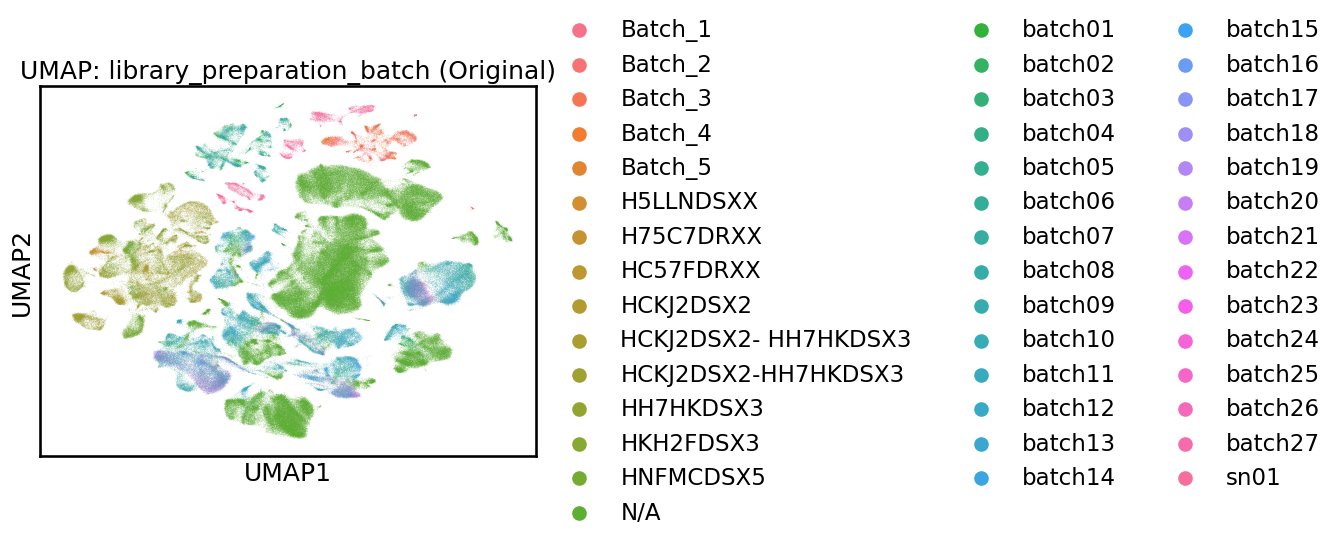

In [20]:
# Check the number of unique values in batch_key
unique_values = adata.obs[batch_key].unique()
num_colors = len(unique_values)

# Generate a color palette based on the number of unique values
colors = sns.color_palette("husl", num_colors)  # You can change "husl" to another palette if desired

plt.figure(figsize=(12, 8))  # Set the figure size to be larger
sc.pl.umap(adata, color=batch_key, palette=colors, show=False)  # Use the generated color palette
plt.title(f'UMAP: {batch_key} (Original)')
plt.show()


In [21]:
combined_palette = {
    'Kropski_Banovich_unpubl.h5ad': '#FF0000',  # Other Pink
    'Yildirim_unpubl.h5ad': '#D5006D',  # Dark Pink

    'Shaykhiev_publ.h5ad': '#FFB6C1',  # Light Pink
    'Schiller_unpubl.h5ad': '#800080',  # Light Yellow (unchanged)
    'Nawijn_unpubl.h5ad': '#0000FF',  # Standard Blue (was Dark Green)
    'lungMAP.h5ad': '#1E90FF',  # Dodger Blue (was Standard Green)
    'Jones_Yosef_Teichmann_Farber_Sims_unpubl.h5ad': '#4682B4',  # Steel Blue (was Yellow-Green)
    'Niklason_Kaminski_publ.h5ad': '#87CEEB'  # Sky Blue (was Light Green)
}


<Figure size 1200x800 with 0 Axes>

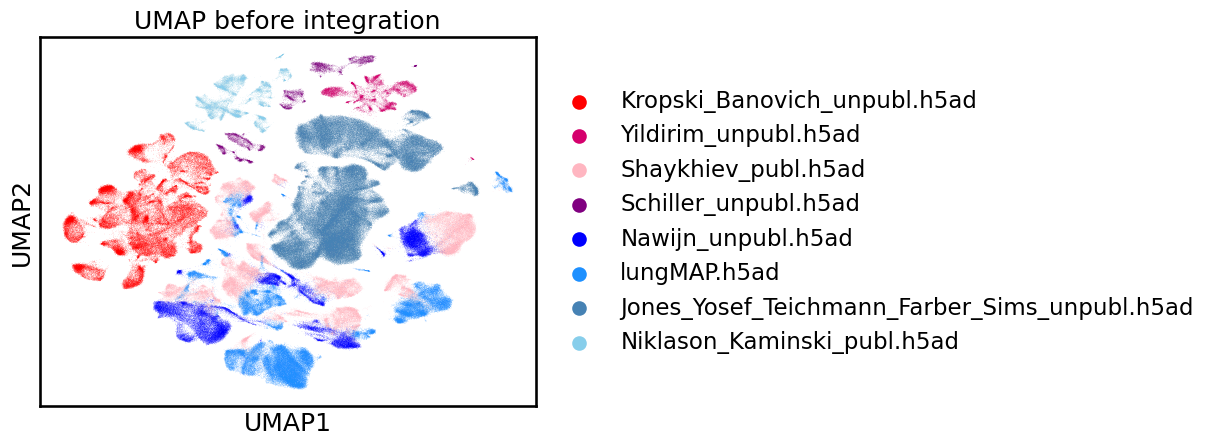

In [22]:
# Define the order of the dataset keys based on the combined_palette
order = list(combined_palette.keys())

# Create a categorical type with the specified order
adata.obs[dataset_key] = pd.Categorical(adata.obs[dataset_key], categories=order, ordered=True)

# Check the number of unique values in dataset_key
unique_values = adata.obs[dataset_key].unique()
num_colors = len(unique_values)

# Create a mapping of dataset keys to their colors
color_mapping = {key: combined_palette[key] for key in unique_values if key in combined_palette}

plt.figure(figsize=(12, 8))  # Set the figure size to be larger
sc.pl.umap(adata, color=dataset_key, palette=color_mapping, show=False)  # Use the defined color mapping
plt.title(f'UMAP before integration')
plt.show()

### Batch-aware feature selection
- don't use sample_id for hvg selection!! - use library_preparation_batch

In [23]:
adata.obs.head()

,sample_ID,donor_id,protocol_URL,institute,sample_collection_site,sample_collection_relative_time_point,library_ID,library_ID_repository,author_batch_notes,organism_ontology_term_id,manner_of_death,sample_source,sex_ontology_term_id,sample_collection_method,tissue_type,sampled_site_condition,tissue_ontology_term_id,tissue_free_text,sample_preservation_method,suspension_type,cell_enrichment,cell_viability_percentage,cell_number_loaded,sample_collection_year,assay_ontology_term_id,library_preparation_batch,library_sequencing_run,sequenced_fragment,sequencing_platform,is_primary_data,reference_genome,gene_annotation_version,alignment_software,intron_inclusion,disease_ontology_term_id,self_reported_ethnicity_ontology_term_id,development_stage_ontology_term_id,author_cell_type,cell_type_ontology_term_id,author_cell_type_markers,author_cell_type_description,celltypist_labels,scanvi_labels,scpoli_labels,n_genes_by_counts,log1p_n_genes_by_counts,total_counts,log1p_total_counts,pct_counts_in_top_20_genes,total_counts_mt,log1p_total_counts_mt,pct_counts_mt,total_counts_ribo,log1p_total_counts_ribo,pct_counts_ribo,total_counts_hb,log1p_total_counts_hb,pct_counts_hb,outlier,mt_outlier,condition,file_name,n_genes
TGCTTCGTCACTCGAA-1_CZINY-0103-6,D496_LNG,D496,doi:10.17504/protocols.io.bwr9pd96,"Columbia University, New York, US",IA_site_2,N/A,"CZINY-0097,CZINY-0098,CZINY-0099,CZINY-0100,CZ...",E-MTAB-11536,N/A,NCBITaxon:9606,0.0,postmortem donor,PATO:0000384,surgical resection,tissue,healthy,UBERON:0008946,Lung parenchyma,fresh,cell,CL:0000842,90.0,NaN,2019.0,EFO:0009922,N/A,N/A,3 prime tag,N/A,True,GRCh38,N/A,cell ranger 6.0.0,yes,PATO:0000461,Hispanic,HsapDv:0000240,macrophage,CL:0000235,NA,NA,Monocyte-derived Mph,Alveolar macrophages,Monocyte-derived Mph,5333,8.581857,29061,10.277187,15.687691,0,0.000000,0.000000,6099,8.716044,20.986890,11,2.484907,0.037851,False,False,normal,Jones_Yosef_Teichmann_Farber_Sims_unpubl.h5ad,5333
TTTGCGCAGATATGCA-1,THD0042,THD0042,https://www.science.org/doi/full/10.1126/sciad...,Translation Genomics Research Institute,TGen/VUMC,N/A,F04637,N/A,N/A,NCBITaxon:9606,NaN,postmortem donor,PATO:0000383,biopsy,tissue,healthy,UBERON:0002048,distal lung,fresh,cell,CL:0000000,NaN,15000.0,2022.0,EFO:0009900,HNFMCDSX5,HNFMCDSX5,5 prime end bias,EFO_0008637,True,GRCh38,v98,cell ranger 7.2.0,yes,PATO:0000461,unknown,HsapDv:0000240,Adventitial fibroblasts,CL:4028006,NA,NA,Unassigned,Club (nasal),CD4 T cells,218,5.389072,232,5.451038,14.655172,0,0.000000,0.000000,1,0.693147,0.431034,0,0.000000,0.000000,False,False,normal,Kropski_Banovich_unpubl.h5ad,218
TAGTTGGCAAGAGTCG-1_CZINY-0523-2,D534_BAL,D534,doi:10.17504/protocols.io.bwrjpd4n,"Columbia University, New York, US",IA_site_2,N/A,"CZINY-0521,CZINY-0522,CZINY-0523,CZINY-0524,CZ...",Not public,N/A,NCBITaxon:9606,0.0,postmortem donor,PATO:0000384,brush,tissue,healthy,UBERON:0000065,Bronchoalveolar Lavage,fresh,cell,CL:0000842,90.0,NaN,2021.0,EFO:0009900,N/A,N/A,5 prime tag,N/A,True,GRCh38,N/A,cell ranger 6.0.0,yes,PATO:0000461,White,HsapDv:0000238,macrophage,CL:0000235,NA,NA,Monocyte-derived Mph,Alveolar macrophages,Monocyte-derived Mph,3504,8.161946,12840,9.460398,20.295950,0,0.000000,0.000000,2102,7.651120,16.370717,3,1.386294,0.023364,False,False,normal,Jones_Yosef_Teichmann_Farber_Sims_unpubl.h5ad,3504
CACCAGGAGCCACGCT-1_CZINY-0713-0,D570_LNG,D570,doi:10.17504/protocols.io.bwr9pd96,"Columbia University, New York, US",IA_site_2,N/A,"CZINY-0713,CZINY-0714,CZINY-0715,CZINY-0716,CZ...",Not public,N/A,NCBITaxon:9606,0.0,postmortem donor,PATO:0000384,surgical resection,tissue,healthy,UBERON:0008946,Lung parenchyma,fresh,cell,CL:0000842,90.0,NaN,2022.0,EFO:0009900,N/A,N/A,5 prime tag,N/A,True,GRCh38,N/A,cell ranger 6.0.0,yes,PATO:0000461,White,HsapDv:0000242,monocyte_classical,CL:0000860,NA,NA,Monocyte-derived Mph,Monocyte-derived Mph,Classical monocytes,2487,7.819234,8015,8.989195,16.107299,0,0.000000,0.000000,1585,7.368970,19.775421,0,0.000000,0.000000,False,False,normal,Jones

In [24]:
sc.pp.highly_variable_genes(
    adata, n_top_genes=4000, flavor="cell_ranger", batch_key='library_preparation_batch'
)
adata
adata.var

,gene_symbols,highly_variable,means,dispersions,dispersions_norm,highly_variable_nbatches,highly_variable_intersection
ensembl_id,,,,,,,
ENSG00000000003,TSPAN6,False,0.110224,0.663237,-0.079565,2,False
ENSG00000000005,TNMD,False,0.000277,0.365958,-0.056815,1,False
ENSG00000000419,DPM1,False,0.111614,0.755001,-0.220836,2,False
ENSG00000000457,SCYL3,False,0.024434,0.732186,-0.204021,0,False
ENSG00000000460,C1orf112,False,0.009036,0.596240,-0.011258,1,False
...,...,...,...,...,...,...,...
nan-993,NaN,False,0.000061,0.008477,-0.039317,0,False
nan-995,NaN,False,0.001978,0.016341,0.002972,0,False
nan-996,NaN,False,0.000147,0.008385,-0.047523,0,False


highly_variable_nbatches
0     8643
1     8599
2     6532
3     4561
4     3161
5     2298
6     1625
7     1155
8      921
9      778
10     548
11     426
12     313
13     311
14     249
15     193
16     178
33     136
17     135
34     131
18     112
20     112
28     110
19     110
30     106
22     105
27     103
23      99
24      97
32      96
29      95
21      94
25      87
31      86
26      81
35      66
36      29
37      10
38      10
39       7
41       5
40       5
42       2
Name: count, dtype: int64

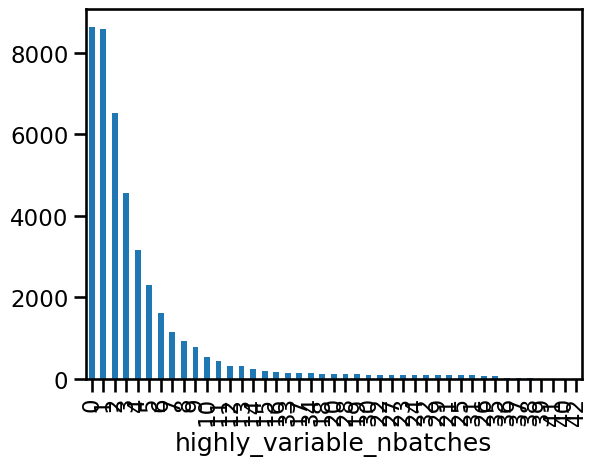

In [25]:
n_batches = adata.var["highly_variable_nbatches"].value_counts()
ax = n_batches.plot(kind="bar")
n_batches

In [26]:
adata_hvg = adata[:, adata.var["highly_variable"]].copy()
adata_hvg

AnnData object with n_obs × n_vars = 587867 × 4000
    obs: 'sample_ID', 'donor_id', 'protocol_URL', 'institute', 'sample_collection_site', 'sample_collection_relative_time_point', 'library_ID', 'library_ID_repository', 'author_batch_notes', 'organism_ontology_term_id', 'manner_of_death', 'sample_source', 'sex_ontology_term_id', 'sample_collection_method', 'tissue_type', 'sampled_site_condition', 'tissue_ontology_term_id', 'tissue_free_text', 'sample_preservation_method', 'suspension_type', 'cell_enrichment', 'cell_viability_percentage', 'cell_number_loaded', 'sample_collection_year', 'assay_ontology_term_id', 'library_preparation_batch', 'library_sequencing_run', 'sequenced_fragment', 'sequencing_platform', 'is_primary_data', 'reference_genome', 'gene_annotation_version', 'alignment_software', 'intron_inclusion', 'disease_ontology_term_id', 'self_reported_ethnicity_ontology_term_id', 'development_stage_ontology_term_id', 'author_cell_type', 'cell_type_ontology_term_id', 'author_cell_t

In [27]:
hvg_path = './data/241001_hvg_data.h5ad'
adata_hvg.write(hvg_path)

In [28]:
adata_hvg = sc.read(hvg_path)

# Data integration

- integrate all normal conditions first

## Integrate all normal conditions

### 1. Variational autoencoder based integration: scvi

In [29]:
adata_scvi = adata_hvg.copy()

In [30]:
# data preparation
scvi.model.SCVI.setup_anndata(adata_scvi, layer="counts", batch_key=batch_key)
adata_scvi

AnnData object with n_obs × n_vars = 587867 × 4000
    obs: 'sample_ID', 'donor_id', 'protocol_URL', 'institute', 'sample_collection_site', 'sample_collection_relative_time_point', 'library_ID', 'library_ID_repository', 'author_batch_notes', 'organism_ontology_term_id', 'manner_of_death', 'sample_source', 'sex_ontology_term_id', 'sample_collection_method', 'tissue_type', 'sampled_site_condition', 'tissue_ontology_term_id', 'tissue_free_text', 'sample_preservation_method', 'suspension_type', 'cell_enrichment', 'cell_viability_percentage', 'cell_number_loaded', 'sample_collection_year', 'assay_ontology_term_id', 'library_preparation_batch', 'library_sequencing_run', 'sequenced_fragment', 'sequencing_platform', 'is_primary_data', 'reference_genome', 'gene_annotation_version', 'alignment_software', 'intron_inclusion', 'disease_ontology_term_id', 'self_reported_ethnicity_ontology_term_id', 'development_stage_ontology_term_id', 'author_cell_type', 'cell_type_ontology_term_id', 'author_cell_t

In [31]:
#build the model
model_scvi = scvi.model.SCVI(adata_scvi)
model_scvi

SCVI model with the following parameters: 
n_hidden: 128, n_latent: 10, n_layers: 1, dropout_rate: 0.1, dispersion: gene, gene_likelihood: zinb, 
latent_distribution: normal.
Training status: Not Trained
Model's adata is minified?: False

In [32]:
model_scvi.view_anndata_setup()

Anndata setup with scvi-tools version 1.1.5.

Setup via `SCVI.setup_anndata` with arguments:

{
│   'layer': 'counts',
│   'batch_key': 'library_preparation_batch',
│   'labels_key': None,
│   'size_factor_key': None,
│   'categorical_covariate_keys': None,
│   'continuous_covariate_keys': None
}

         Summary Statistics          
┏━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓
┃     Summary Stat Key     ┃ Value  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━┩
│         n_batch          │   43   │
│         n_cells          │ 587867 │
│ n_extra_categorical_covs │   0    │
│ n_extra_continuous_covs  │   0    │
│         n_labels         │   1    │
│          n_vars          │  4000  │
└──────────────────────────┴────────┘

               Data Registry                
┏━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Registry Key ┃    scvi-tools Location    ┃
┡━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      X       │  adata.layers['counts']   │
│    batch     │ adata.obs['_scvi_batch']  │
│    labels    │ adata.obs['_scvi_labels'] │
└──────────────┴───────────────────────────┘

                                 batch State Registry                                  
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃            Source Location             ┃      Categories      ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['library_preparation_batch'] │       Batch_1        │          0          │
│                                        │       Batch_2        │          1          │
│                                        │       Batch_3        │          2          │
│                                        │       Batch_4        │          3          │
│                                        │       Batch_5        │          4          │
│                                        │      H5LLNDSXX       │          5          │
│                                        │      H75C7DRXX       │          6          │
│                                        │      HC57FDRXX       │          7          │
│                                        │      HCKJ2DSX2       │          8          │
│                                        │ HCKJ2DSX2- HH7HKDSX3 │          9          │
│                                        │ HCKJ2DSX2-HH7HKDSX3  │         10          │
│                                        │      HH7HKDSX3       │         11          │
│                                        │      HKH2FDSX3       │         12          │
│                                        │      HNFMCDSX5       │         13          │
│                                        │         N/A          │         14          │
│                                        │       batch01        │         15          │
│                                        │       batch02        │         16          │
│                                        │       batch03        │         17          │
│                                        │       batch04        │         18          │
│                                        │       batch05        │         19          │
│                                        │       batch06        │         20          │
│                                        │       batch07        │         21          │
│                                        │       batch08        │         22          │
│                                        │       batch09        │         23          │
│                                        │       batch10        │         24          │
│                                        │       batch11        │         25          │
│                                        │       batch12        │         26          │
│                                        │       batch13        │         27          │
│                                        │       batch14        │         28          │
│                                        │       batch15        │         29          │
│                                        │       batch16        │         30          │
│                                        │       batch17        │         31          │
│                                        │       batch18        │         32          │
│                                        │       batch19        │         33          │
│                                        │       batch20        │         34          │
│                                        │       batch21        │         35          │
│                                        │       batch22        │         36          │
│                                        │       batch23        │         37          │
│                                        │       batch24        │         38          │
│                                        │       batch25        │         39          │
│                                        │       batch26        │         40          │
│                                       

                     labels State Registry                      
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃      Source Location      ┃ Categories ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['_scvi_labels'] │     0      │          0          │
└───────────────────────────┴────────────┴─────────────────────┘

In [33]:
#Train
max_epochs_scvi = np.min([round((20000 / adata_hvg.n_obs) * 400), 400])
max_epochs_scvi

14

In [34]:
model_scvi.train()

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 14/14: 100%|█| 14/14 [06:55<00:00, 28.45s/it, v_num=1, train_loss_step=1.0

`Trainer.fit` stopped: `max_epochs=14` reached.


Epoch 14/14: 100%|█| 14/14 [06:55<00:00, 29.65s/it, v_num=1, train_loss_step=1.0


In [35]:
#extract the embedding
adata_scvi.obsm["X_scVI"] = model_scvi.get_latent_representation()

In [36]:
#calculate a batch-corrected UMAP
sc.pp.neighbors(adata_scvi, use_rep="X_scVI")
sc.tl.umap(adata_scvi)
adata_scvi

AnnData object with n_obs × n_vars = 587867 × 4000
    obs: 'sample_ID', 'donor_id', 'protocol_URL', 'institute', 'sample_collection_site', 'sample_collection_relative_time_point', 'library_ID', 'library_ID_repository', 'author_batch_notes', 'organism_ontology_term_id', 'manner_of_death', 'sample_source', 'sex_ontology_term_id', 'sample_collection_method', 'tissue_type', 'sampled_site_condition', 'tissue_ontology_term_id', 'tissue_free_text', 'sample_preservation_method', 'suspension_type', 'cell_enrichment', 'cell_viability_percentage', 'cell_number_loaded', 'sample_collection_year', 'assay_ontology_term_id', 'library_preparation_batch', 'library_sequencing_run', 'sequenced_fragment', 'sequencing_platform', 'is_primary_data', 'reference_genome', 'gene_annotation_version', 'alignment_software', 'intron_inclusion', 'disease_ontology_term_id', 'self_reported_ethnicity_ontology_term_id', 'development_stage_ontology_term_id', 'author_cell_type', 'cell_type_ontology_term_id', 'author_cell_t

Dataset plot:

Unique values for color in adata: Index(['Kropski_Banovich_unpubl.h5ad', 'Yildirim_unpubl.h5ad',
       'Shaykhiev_publ.h5ad', 'Schiller_unpubl.h5ad', 'Nawijn_unpubl.h5ad',
       'lungMAP.h5ad', 'Jones_Yosef_Teichmann_Farber_Sims_unpubl.h5ad',
       'Niklason_Kaminski_publ.h5ad'],
      dtype='object')
Palette used for plotting: ['#FF0000', '#D5006D', '#FFB6C1', '#800080', '#0000FF', '#1E90FF', '#4682B4', '#87CEEB']


<Figure size 1200x800 with 0 Axes>

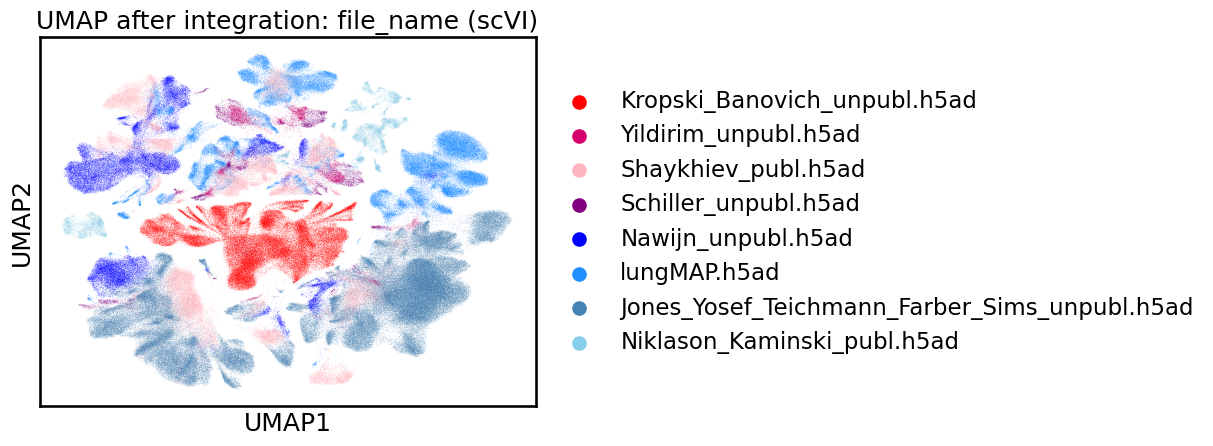

In [37]:
def plot_umap_custom(adata, color, title, palette_dict):
    plt.figure(figsize=(12, 8))
    
    # Extract categories in the correct order
    if adata.obs[color].dtype.name == 'category':
        unique_values = adata.obs[color].cat.categories
    else:
        unique_values = adata.obs[color].unique()
    
    print("Unique values for color in adata:", unique_values)
    
    # Create a palette list matching the order of unique values
    palette = [palette_dict.get(value, "#808080") for value in unique_values]
    
    # Debugging: Check the final palette
    print("Palette used for plotting:", palette)
    
    # Plot UMAP
    sc.pl.umap(adata, color=color, palette=palette, show=False)
    plt.title(title)
    plt.show()

# Use the function for plotting
plot_umap_custom(adata_scvi, dataset_key, f'UMAP after integration: {dataset_key} (scVI)', combined_palette)


Batch plot:

<Figure size 1200x800 with 0 Axes>

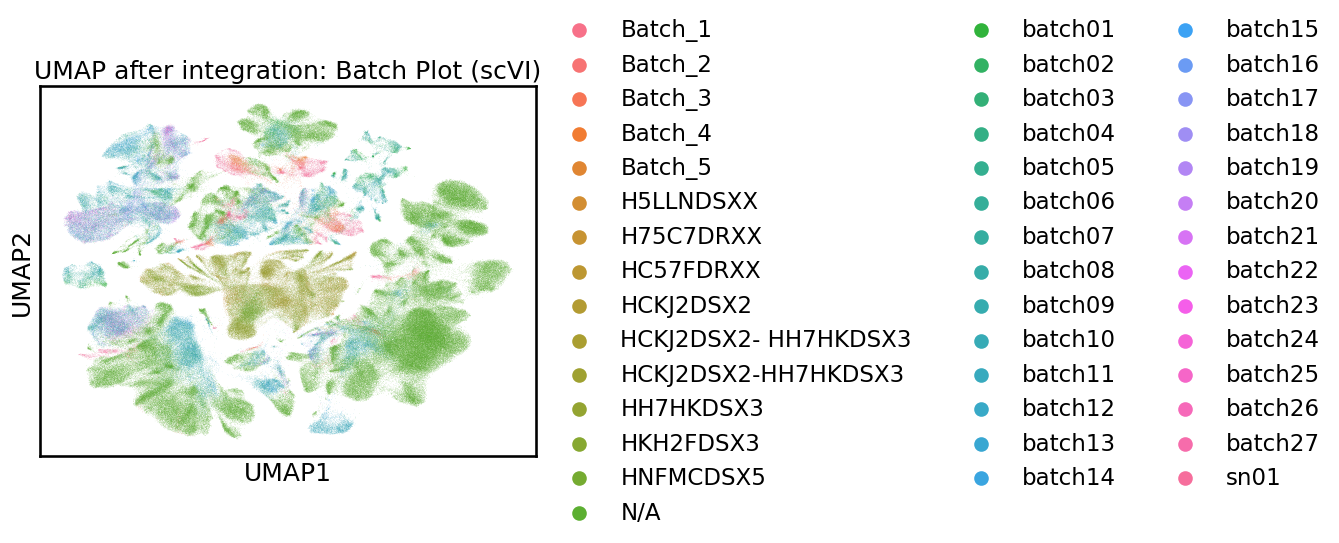

In [38]:
# For Batch Plot Palette
batch_palette = sns.color_palette("husl", len(adata_hvg.obs[batch_key].unique()))

# For Cell Type Plot Palette (using 'husl' or another valid palette)
cell_type_palette = sns.color_palette("husl", len(adata_hvg.obs[label_key].unique()))

def plot_umap(adata, color, title, palette):
    plt.figure(figsize=(12, 8))
    sc.pl.umap(adata, color=color, palette=palette, show=False)
    plt.title(title)
    plt.show()

# Example Usage:
plot_umap(adata_scvi, color=batch_key, title="UMAP after integration: Batch Plot (scVI)", palette=batch_palette)


Cell type plot:

<Figure size 1200x800 with 0 Axes>

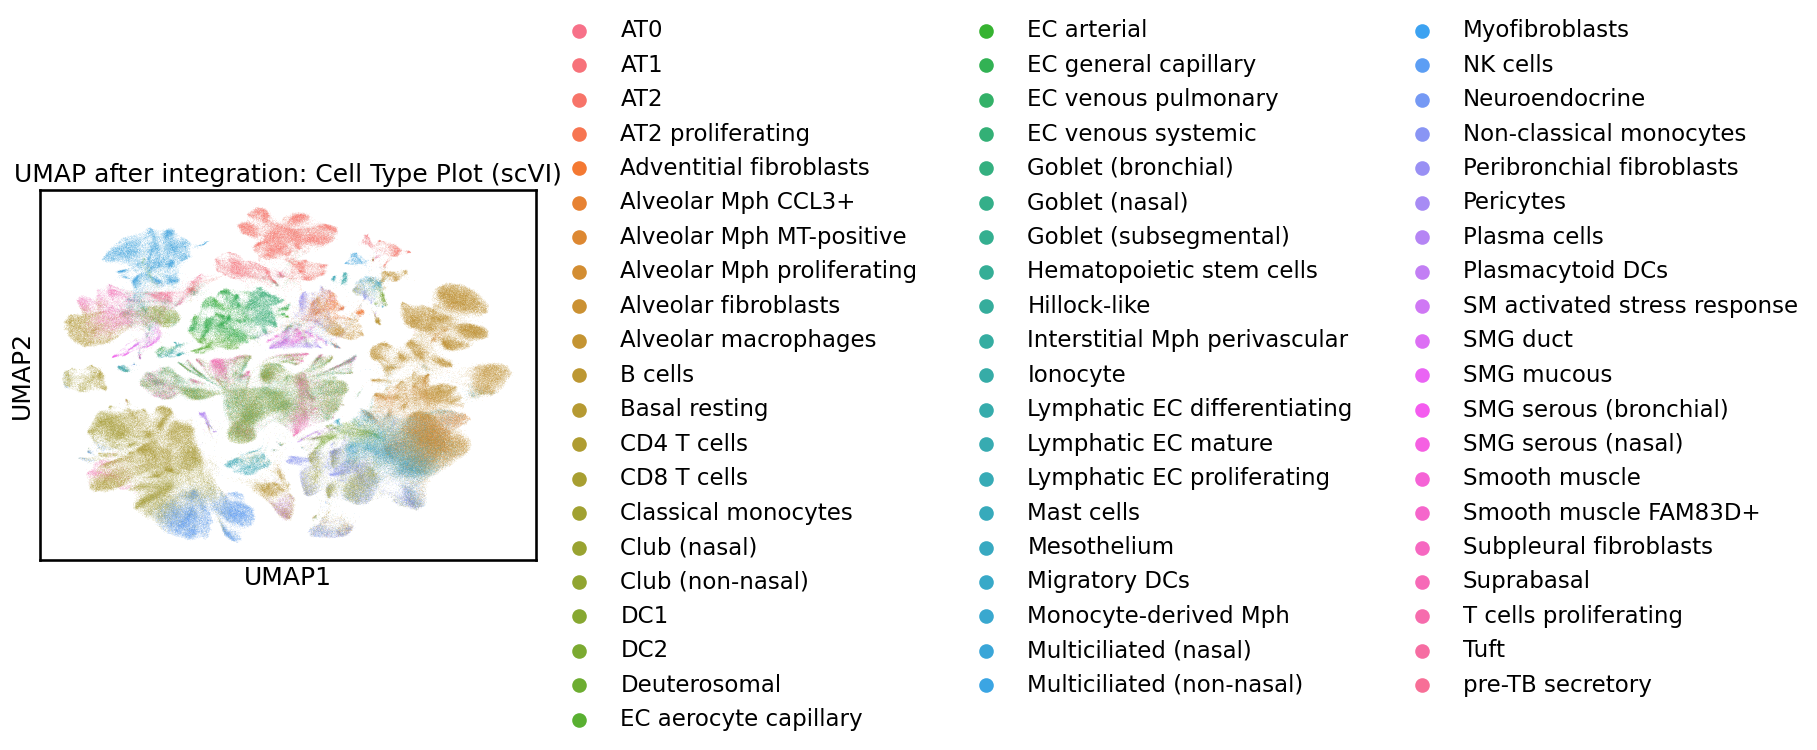

In [39]:
plot_umap(adata_scvi, color=label_key, title="UMAP after integration: Cell Type Plot (scVI)", palette=cell_type_palette)

### 2. BBKNN

In [40]:
neighbors_within_batch = 25 if adata_hvg.n_obs > 100000 else 3
neighbors_within_batch


adata_bbknn = adata_hvg.copy()
adata_bbknn.X = adata_bbknn.layers["logcounts"].copy()
sc.pp.pca(adata_bbknn)

bbknn.bbknn(
    adata_bbknn, batch_key=batch_key, neighbors_within_batch=neighbors_within_batch
)


sc.tl.umap(adata_bbknn)


In [41]:
# Set neighbors_within_batch based on the number of observations
neighbors_within_batch = 25 if adata_hvg.n_obs > 100000 else max(5, 3)

# Create a copy of the AnnData object
adata_bbknn = adata_hvg.copy()

# Set the .X matrix to use logcounts layer
adata_bbknn.X = adata_bbknn.layers["logcounts"].copy()

# Perform PCA
sc.pp.pca(adata_bbknn)

# Run BBKNN with the specified batch key and neighbors_within_batch
bbknn.bbknn(
    adata_bbknn, batch_key=batch_key, neighbors_within_batch=neighbors_within_batch
)

# Calculate UMAP
sc.tl.umap(adata_bbknn)


Unique values for color in adata: Index(['Kropski_Banovich_unpubl.h5ad', 'Yildirim_unpubl.h5ad',
       'Shaykhiev_publ.h5ad', 'Schiller_unpubl.h5ad', 'Nawijn_unpubl.h5ad',
       'lungMAP.h5ad', 'Jones_Yosef_Teichmann_Farber_Sims_unpubl.h5ad',
       'Niklason_Kaminski_publ.h5ad'],
      dtype='object')
Palette used for plotting: ['#FF0000', '#D5006D', '#FFB6C1', '#800080', '#0000FF', '#1E90FF', '#4682B4', '#87CEEB']


<Figure size 1200x800 with 0 Axes>

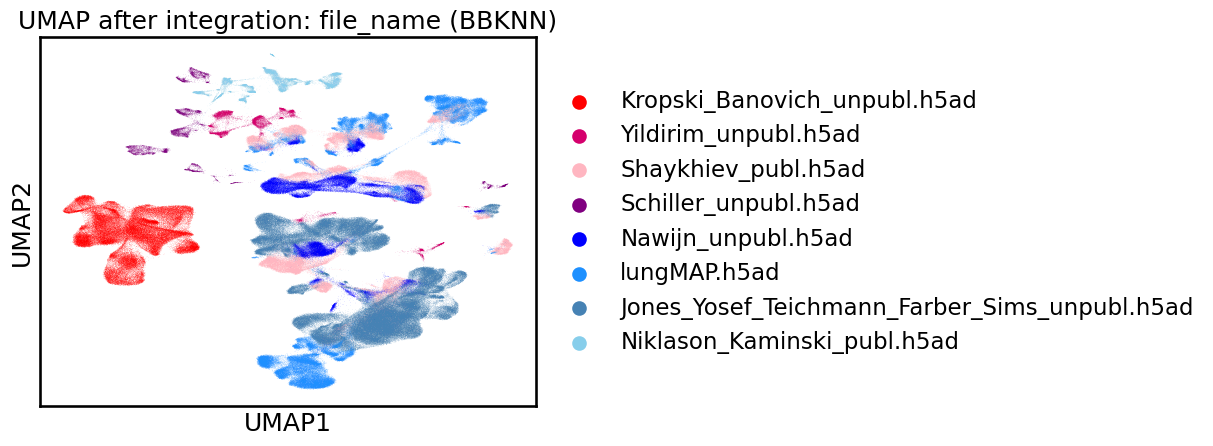

In [42]:
plot_umap_custom(adata_bbknn, dataset_key, f'UMAP after integration: {dataset_key} (BBKNN)', combined_palette)

<Figure size 1200x800 with 0 Axes>

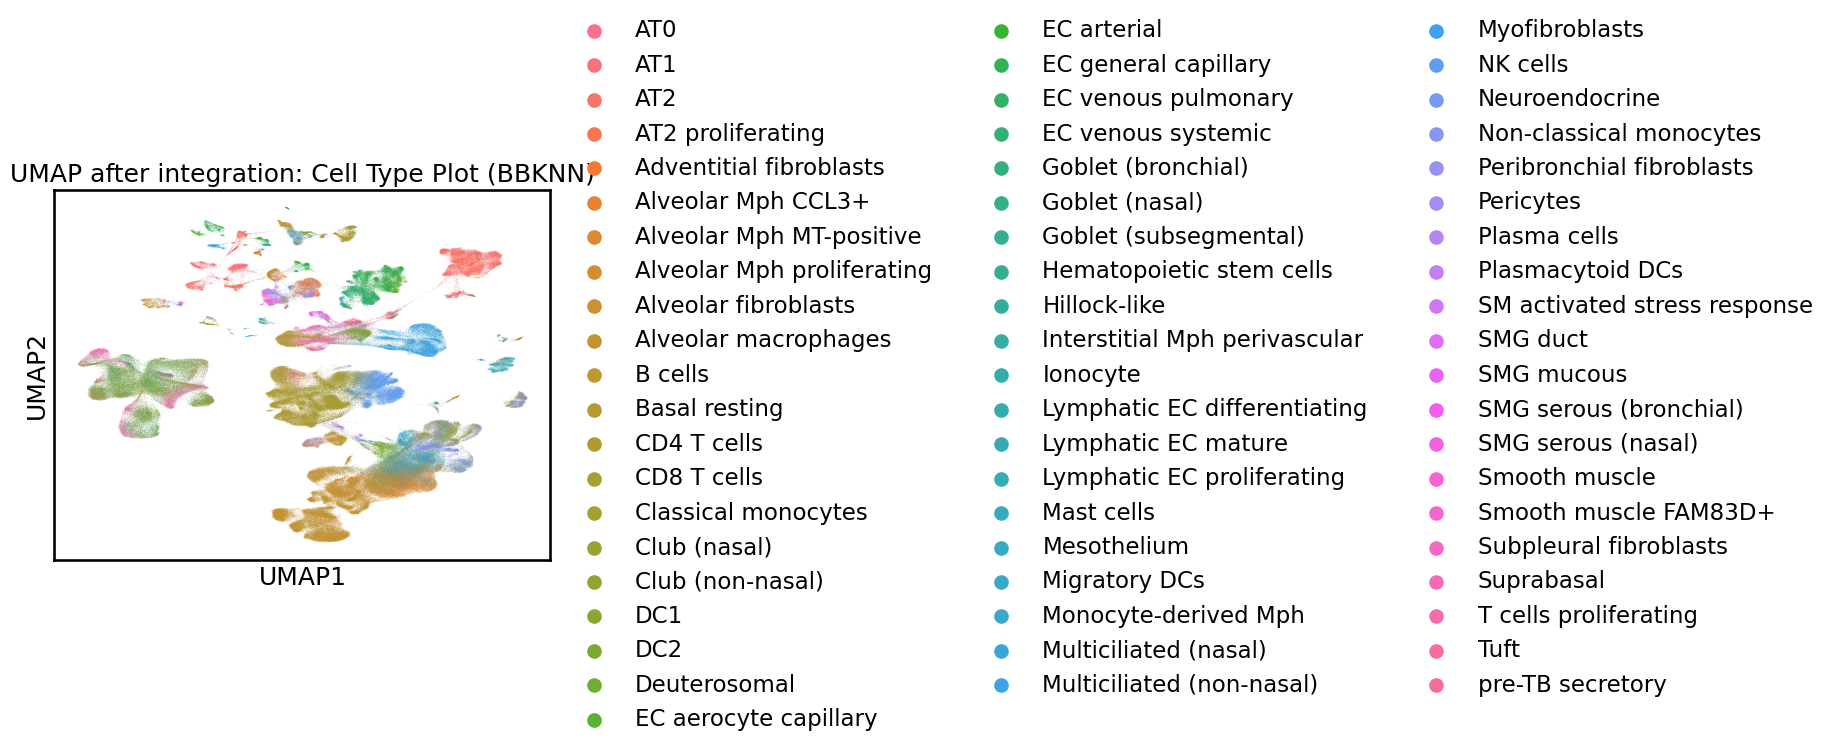

In [43]:
plot_umap(adata_bbknn, color=label_key, title="UMAP after integration: Cell Type Plot (BBKNN)", palette=cell_type_palette)